#### This jupyter notebook uses: <br> <br>1) the FM-factors for the transcriptome after gene knockdown generated in Example2_generate_FM_matrix.ipynb, <br> 2) the FM-factors for the transcriptome after drug treatment in Example1-generate-FM-matrix.ipynb,<br>  3) the five states annotated by concensus clustering method in Example1-comparing-clustering-annotation.ipynb, <br><br>and uses the KNN method to predict the transcriptome after gene knockdown to the states after drug treatment. 

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import scipy 
import scipy.stats as ss
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
#from FM_States import *
import rpy2
from rpy2.robjects.packages import importr
from sklearn.neighbors import KNeighborsClassifier
import random

base = importr('base')
CC = importr('ConsensusClusterPlus')
pheatmap = importr('pheatmap')

ROOT_DIR = os.path.abspath("../")

#### File input

In [3]:
para = {
    'output_dir': ROOT_DIR+"/Sample_output/Example2/",
    'input_fmf_file_drug': ROOT_DIR +  "/Sample_output/Example1/matrix_factor_mcf7.csv",
    'input_fmf_file_sh':ROOT_DIR + "/Sample_output/Example2/matrix_factor_sh_mcf7.csv",
    'annotation_col':ROOT_DIR + "/Sample_output/Example1/annotation_col.csv",
    'selected_factor':ROOT_DIR +"/Sample_output/Example1/Features_diff_all.csv",
    'meta':ROOT_DIR + '/Sample_input/Example2/MetaData_sig_info_sh_MCF7_96h.csv'
}

In [4]:
output_dir = para['output_dir']
try:
    os.makedirs(output_dir)
except OSError:
    print ("Info: Creation of the directory failed!\nThe direcory of %s may already exsit!" % output_dir)
else:
    print ("Successfully created the directory %s " % output_dir)
    

Info: Creation of the directory failed!
The direcory of /project/Sample_output/Example2/ may already exsit!


#### Read files

In [5]:
matrix_factor_sh_MCF7 = pd.read_csv(para['input_fmf_file_sh'], index_col = 'Unnamed: 0')
matrix_factor = pd.read_csv(para['input_fmf_file_drug'], index_col = 'Unnamed: 0')
annotation_col_1 = pd.read_csv(para['annotation_col'], index_col= 'Unnamed: 0')
colors = ['#ff8080','pink','#fdd5ac','#8895df', 'cyan'] #Define the colors for cluster annotation
output_dir = para['output_dir']
select_modules =pd.read_csv(para['selected_factor'],index_col= 'Unnamed: 0')
meta_sh = pd.read_csv(para['meta'])  ## Annotation data for shRNA
meta_sh.index = meta_sh['sig_id']

### KNN model

In [6]:
from sklearn.neighbors import KNeighborsClassifier
import random
y = annotation_col_1.loc[list(matrix_factor.index.values)]  ## use the states after drug treatment as labels;
x = matrix_factor[list(select_modules)].values              ## use the states after drug treatment as training set;
y_test = matrix_factor_sh_MCF7[list(select_modules)]        ## use the FM-factors after shRNA knockdown as the testing set;

In [7]:
states = sorted(list(set(annotation_col_1['States'])))
dic_train = {}
dic_test = {}
score_dic_train = {}
score_dic_test = {}
pred_model ={}

for num_neighbors in [5]: # K == 5 was chose as it give a higher accuracy and lower variance. see KNN_parameter_estimation.ipynb
    score_list_train = []
    score_list_test = []
    
    sample_forTrain = list(matrix_factor.index.values)
    pd_x_train = matrix_factor.loc[sample_forTrain][list(select_modules)]
    x_train = pd_x_train.values
    y_train = annotation_col_1.loc[sample_forTrain]['States']
        
    
    neigh = KNeighborsClassifier(n_neighbors = num_neighbors)
    neigh.fit(x_train, y_train) 

    score_list_train.append(neigh.score(x_train,y_train))
        
    predicted_label = (neigh.predict(y_test.dropna().values))
    predicted_probability = neigh.predict_proba(y_test.dropna().values)
  
    score_dic_train[num_neighbors] = score_list_train
    
score_df_train = pd.DataFrame.from_dict(score_dic_train)
score_df_test = pd.DataFrame.from_dict(score_dic_test)


In [8]:
prediction_result_knn = pd.DataFrame({'Sample': list(y_test.dropna().index.values), 'State':list(predicted_label)})
df = pd.DataFrame(data=predicted_probability,columns =["S1", "S2","S3","S4","S5"], index= y_test.dropna().index.values)
result = pd.DataFrame({"Sample": df.max(axis = 1).index, "Prob":df.max(axis = 1).values }) 
result_selected = prediction_result_knn.loc[prediction_result_knn['Sample'].isin(result.loc[result['Prob']>=0.6]['Sample'] )]

### Number of samples classified to each state

In [9]:
dic_sh_state = {}
for state in states:
    dic_sh_state[state] = list(result_selected.loc[result_selected['State'] ==  state]['Sample'].values)

In [10]:
Num_Seeds_state = []
for state in states:
    Num_Seeds_state.append(len(dic_sh_state[state])) 

print(Num_Seeds_state)

[5693, 3192, 1909, 168, 1045]


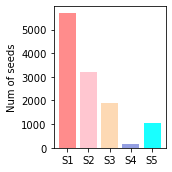

In [11]:
colors = ['#ff8080','pink','#fdd5ac','#8895df', 'cyan'] #Define the colors for cluster annotation

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))

#print(Num_Seeds_state)

objects = states
y_pos = np.arange(len(objects))
plt.bar(y_pos,Num_Seeds_state, align='center', alpha=0.9,color=colors[0:len(objects)])
plt.xticks(y_pos, objects)
plt.ylabel('Num of seeds')
plt.tight_layout()
plt.savefig(output_dir+'/Num_seeds_wholeSet.png', dpi=300)
plt.show()

### Genes classified to each state

In [12]:
def getLabel_forGene(Gene, dic_sh_state, meta_sh):
    result = []
    result_df = pd.DataFrame()
    dic_Num = {}
    for state in states:
        dic_Num[state] = set(dic_sh_state[state]).intersection(set(meta_sh.loc[meta_sh['pert_iname'] == Gene]['sig_id']))
    
    for state in states:
        if len(dic_Num[state] ) > 0:
            A = len(dic_Num[state])  #Number of seeds for one gene in the state
            B = 0
            for state2 in states:
                if state2 != state:
                    B = B + len(dic_Num[state2])  #Number of seeds for one gene in other states
                    
            C = len(dic_sh_state[state]) - A   #Number of other seeds in the state
            D = 0
            for state2 in states:
                if state2 != state:
                    D = D + len(dic_sh_state[state2])
            D = D - B           #Number of other seeds in all other states
            
            oddsratio, pvalue = scipy.stats.fisher_exact([[A, B], [C, D]], alternative = 'greater')
            if(pvalue < 0.05 ):  #user defination
                result.append(Gene)
                result.append(state)
                result.append(pvalue)
                result.append(oddsratio)
                result.append(A)
    if(len(result) > 0):
        return(result[0],result[1], result[2], result[3],result[4])
    else:
        return()

In [13]:
genelist = []
Lable_list = []
P_list = []
o_list = []
C_list = []
for gene in set(meta_sh['pert_iname']):
    if(len(getLabel_forGene(gene,  dic_sh_state, meta_sh)) >4):  #if pvalue < 0.1
        G,S,P,O,N = getLabel_forGene(gene, dic_sh_state, meta_sh)
        Lable_list.append(S)
        genelist.append(G)
        P_list.append(P) 
        o_list.append(O) 
        C_list.append(N)
        
Result = pd.DataFrame({"Gene":genelist,"Label":Lable_list, 'P_value':P_list, "OddRatio":o_list, "Num":C_list})


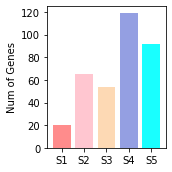

In [14]:
ylist = []
for state in states:
    ylist.append( (Result.loc[Result['Label'] == state].shape[0]) )

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))

objects = states
y_pos = np.arange(len(objects))
plt.bar(y_pos,ylist, align='center', alpha=0.9,color=colors[0:len(objects)])
plt.xticks(y_pos, objects)
plt.ylabel('Num of Genes')
plt.tight_layout()
plt.savefig(output_dir+'/Num_Genes_allSet.png', dpi=300)
plt.show()

In [15]:
Result.to_csv(output_dir + "Predicted_gene_allSet2.csv")


In [16]:
label = []
sample = []
for state in list(dic_sh_state.keys()):
    for i in range(0, len(dic_sh_state[state])):
        label.append(state)
        sample.append(dic_sh_state[state][i])
        
Result_sample = pd.DataFrame({"Sample":sample, 'State':label})
Result_sample.to_csv(output_dir + "Predicted_sample_allSet.csv")

#### Check Example2_Depmap-allSet.ipynb for follow up analysis.